# Recommender Systems

### Libraries

In [529]:
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, SVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from collections import Counter, defaultdict
from utils import load_filtered_data

### Reviews data

In [530]:
# major variables

city = 'Springfield'
city_data = load_filtered_data(city)

In [531]:
# data frame of business reviews by users

reviews = city_data['review'][['review_id', 'business_id', 'user_id', 'stars']]
reviews = reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()
reviews.columns = ['user_id', 'business_id', 'rating']

In [532]:
reviews.sample(5)

,user_id,business_id,rating
6901,c7er_FY0yQ7WA6pWOKGPCA,Rt4xYQBWC8i2xqLp9dP7XQ,1.0
75,-TtdINMahEzwbmyFkaY-AA,3ITQFzCEeBoG-gDvhi2hBA,5.0
10952,z1FuO0yrW-I9lcqDeLQ8ZQ,nMxfEiAANa_FsrCZZVHoEg,1.0
10711,xSe759brFUJ5w1VIxZXWzQ,z0wMbtkOYQoErR5wHWAuzw,5.0
7840,h8SIncN1VOS6p4BDMb4xMg,ZslqrrUvqh7gzSPSShgmDA,4.0


In [533]:
# number of ratings

len(reviews['rating'])

11145

In [534]:
# number of users who have reviewed

len(reviews['user_id'].unique())

7350

In [535]:
# ratings statistics

reviews['rating'].describe()

count    11145.000000
mean         3.170151
std          1.620381
min          1.000000
25%          1.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

<Axes: >

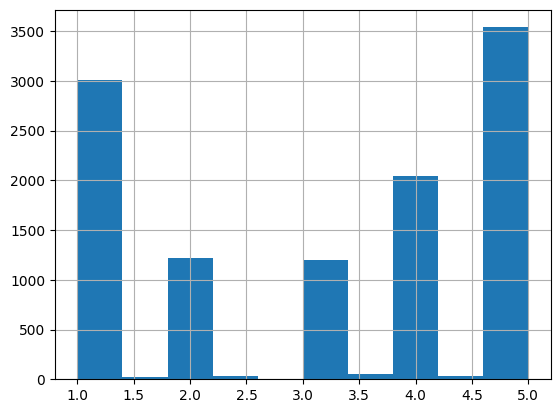

In [536]:
# ratings distribution

reviews['rating'].hist()

### User-business matrix

In [537]:
# city matrix

city_matrix = reviews.pivot(index='user_id', columns='business_id', values='rating')

In [538]:
city_matrix.sample(5)

business_id,-2HaAaQODTx0sr2srL553Q,-Ll6x0_5Fr_bA72f7u4ngg,-PU5on8H21jZOqSXCmxLJQ,-SP57kb0YH5OVygMepc-mg,-Y3htUtPT7AMBgjx9R9PhQ,-wpjPXundFyZCm9khW2wLg,07aiOK7W40KIAgEYeHES_Q,0GYqOZwfs9eZGLdb5HCFLQ,0PwifSf0hCjUHyBrCVW8Vg,0XHO9Af7O0GQ6ynGmJmjJw,...,yYbKiItwE3eQIP_yI_26Ug,yamAA4kSOegaxFjhGhI0OQ,yf1fXCSYCKvUGUgv5KaInA,yu59hTO1Qxopb-cIqCVoaQ,yyGp1_3i_zhfpBVIY4Xaww,z0wMbtkOYQoErR5wHWAuzw,z629liAiGofiHqCaD5lI5g,zEn2eDg7S_oUBgIosW2d7w,zFgTyhoY1O6WiPdK5n0clQ,zuBauP4SFrV_aFiipupA_w
user_id,,,,,,,,,,,,,,,,,,,,,
g1bm02MfjRA3rbGW8y6MNw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12IwgJaLYa2FnBbDk9JtQQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9uHtt9lJ0nqByEJtXrdnww,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jD8Hen-TN1QJDWBq2LG1TA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AxjzdOvzzQU4FS6A5Zrptg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [539]:
# city matrix sparsity

print(f"{city_matrix.notnull().sum().sum() / (city_matrix.shape[0] * city_matrix.shape[1]):.2%}")

0.39%


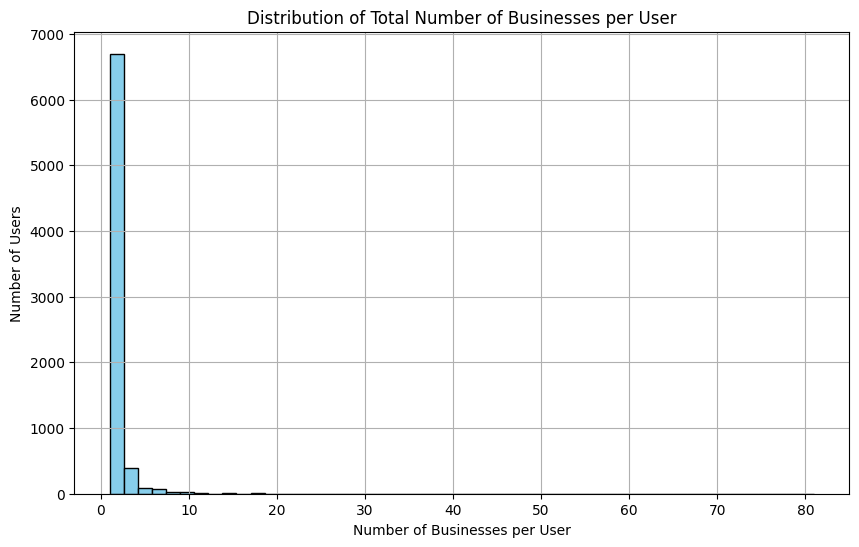

In [540]:
# distribution of total number of items per user

businesses_per_user = city_matrix.notnull().sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(businesses_per_user, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Number of Businesses per User')
plt.xlabel('Number of Businesses per User')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

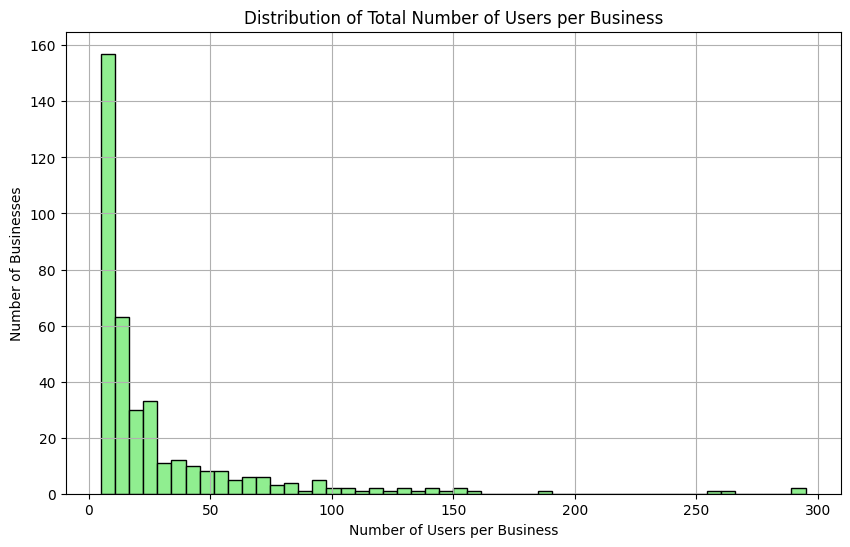

In [541]:
# distribution of total number of users per business

users_per_business = city_matrix.notnull().sum()
plt.figure(figsize=(10, 6))
plt.hist(users_per_business, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Total Number of Users per Business')
plt.xlabel('Number of Users per Business')
plt.ylabel('Number of Businesses')
plt.grid(True)
plt.show()

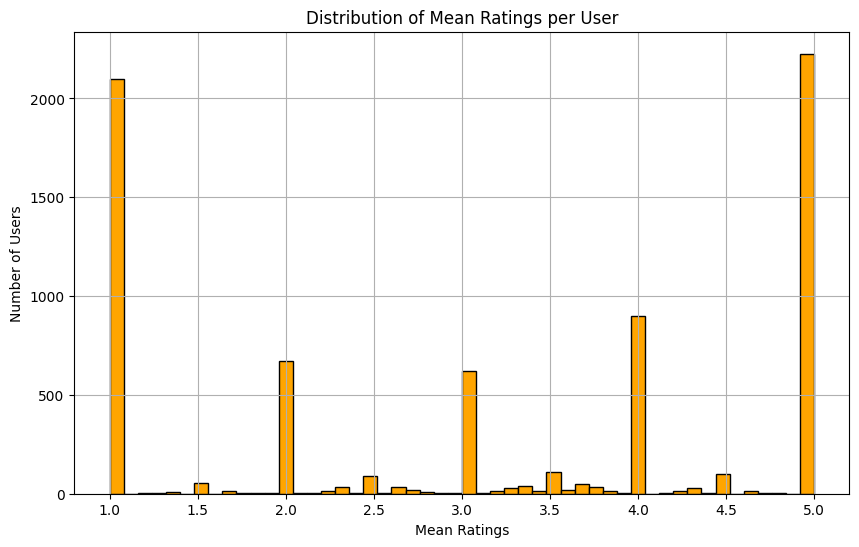

In [542]:
# distribution of mean ratings per user

mean_ratings_per_user = city_matrix.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(mean_ratings_per_user, bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Mean Ratings per User')
plt.xlabel('Mean Ratings')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

### Community matrices

In [543]:
# user-business matrix for each community

connection = 'priority_combined'
with open(f'communities/{city}_{connection}_communities.json') as f:
    data = json.load(f)

community_matrices = {}
for i, community in enumerate(data['communities']):
    community_matrices[i] = reviews[reviews['user_id'].isin(community)]
    community_matrices[i] = community_matrices[i].pivot_table(index='user_id', columns='business_id', values='rating')

In [544]:
community_matrices[0].sample(5)

business_id,-2HaAaQODTx0sr2srL553Q,-PU5on8H21jZOqSXCmxLJQ,-SP57kb0YH5OVygMepc-mg,-Y3htUtPT7AMBgjx9R9PhQ,-wpjPXundFyZCm9khW2wLg,0GYqOZwfs9eZGLdb5HCFLQ,0PwifSf0hCjUHyBrCVW8Vg,0XHO9Af7O0GQ6ynGmJmjJw,0dh-UzCeq3d7EkEOC2eo6Q,0n6alVslpokrrvdrlp871A,...,yYbKiItwE3eQIP_yI_26Ug,yamAA4kSOegaxFjhGhI0OQ,yf1fXCSYCKvUGUgv5KaInA,yu59hTO1Qxopb-cIqCVoaQ,yyGp1_3i_zhfpBVIY4Xaww,z0wMbtkOYQoErR5wHWAuzw,z629liAiGofiHqCaD5lI5g,zEn2eDg7S_oUBgIosW2d7w,zFgTyhoY1O6WiPdK5n0clQ,zuBauP4SFrV_aFiipupA_w
user_id,,,,,,,,,,,,,,,,,,,,,
btYTmIsiqLPTABFiK_Wegg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LLHYY86MdyvBJfao2wDtlg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XhGCAPGI_GEzeV7v-s9RBQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PpSHkQZW54jq5NXAlwcwyA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tLwgsdOAHUuGKc7uWZUPxQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Community 0: 0.64% sparsity
Community 1: 50.00% sparsity
Community 2: 4.73% sparsity
Community 3: 2.53% sparsity
Community 4: 2.23% sparsity
Community 5: 4.44% sparsity
Community 6: 100.00% sparsity
Community 7: 3.24% sparsity
Community 8: 100.00% sparsity
Community 9: 50.00% sparsity
Community 10: nan% sparsity
Community 11: 33.33% sparsity
Community 12: 33.33% sparsity
Community 13: 15.20% sparsity
Community 14: 100.00% sparsity
Community 15: nan% sparsity
Community 16: nan% sparsity
Community 17: 1.64% sparsity
Community 18: 3.11% sparsity
Community 19: 5.79% sparsity
Community 20: 2.03% sparsity
Community 21: nan% sparsity
Community 22: 33.33% sparsity
Community 23: 100.00% sparsity
Community 24: nan% sparsity
Community 25: nan% sparsity
Community 26: 4.33% sparsity
Community 27: 2.29% sparsity
Community 28: 7.50% sparsity
Community 29: nan% sparsity
Community 30: nan% sparsity
Community 31: 33.33% sparsity
Community 32: 3.94% sparsity
Community 33: 1.92% sparsity
Community 34: 50.

/tmp/ipykernel_7434/1571772511.py:6: RuntimeWarning: invalid value encountered in scalar divide
  sparsity[community_id] = matrix.notnull().sum().sum() / (matrix.shape[0] * matrix.shape[1])


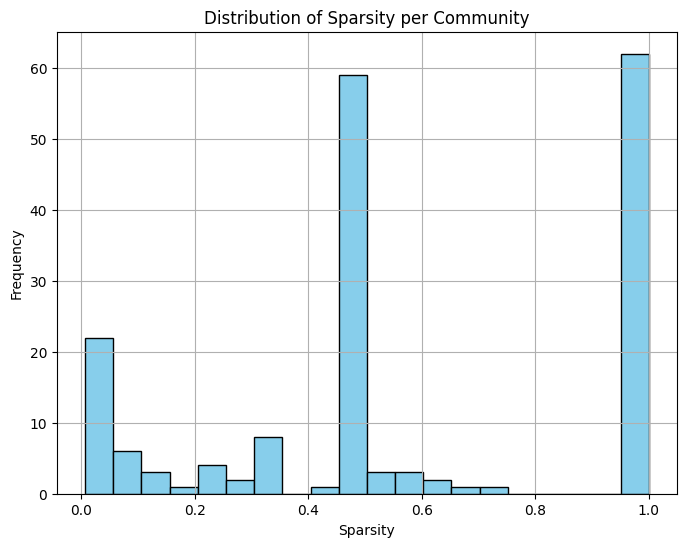

In [545]:
# data sparsity

sparsity = {}

for community_id, matrix in community_matrices.items():
    sparsity[community_id] = matrix.notnull().sum().sum() / (matrix.shape[0] * matrix.shape[1])

for community_id, sparsity_value in sparsity.items():
    print(f"Community {community_id}: {sparsity_value:.2%} sparsity")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(sparsity.values(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sparsity per Community')
plt.xlabel('Sparsity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Train and test sets

In [546]:
community_trainsets = {}
community_testsets = {}

for community_id, matrix in community_matrices.items():
    matrix_filtered = matrix[matrix >= 3].dropna(axis=0, how='all')

    user_review_counts = matrix_filtered.apply(lambda row: row.count(), axis=1)
    users_with_min_reviews = user_review_counts[user_review_counts >= 3].index.tolist()
    print(user_review_counts)
    matrix_filtered = matrix_filtered.loc[users_with_min_reviews]
    df = matrix_filtered.stack().reset_index()
    df.columns = ['user_id', 'business_id', 'rating']

    trainset = defaultdict(list)
    testset = defaultdict(list)
    for user_id, group in df.groupby('user_id'):
        num_reviews = len(group)
        train_size = int(num_reviews * 0.8)
        train_reviews = group[:train_size]
        test_reviews = group[train_size:]
        trainset[community_id].extend(train_reviews.values.tolist())
        testset[community_id].extend(test_reviews.values.tolist())

    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(pd.DataFrame(trainset[community_id], columns=['user_id', 'business_id', 'rating']), reader)
    test_data = Dataset.load_from_df(pd.DataFrame(testset[community_id], columns=['user_id', 'business_id', 'rating']), reader)

    community_trainsets[community_id] = train_data.build_full_trainset()
    community_testsets[community_id] = test_data.build_full_trainset().build_testset()

user_id
-18_TmfN3l667ukOYRGPzw    1
-2fEkE_j7_syVn6hwbEuUQ    3
-6y3e3PSQZvbVzz0KinimA    1
-H2Ja5gFeGsPrEq9o_ufiA    1
-MeResg7zWIywg7JwuMvaw    1
                         ..
zp-XjxYQPY1w8Le6GzI25Q    1
ztDSO7DSGNtPN_XW5VFjvg    8
zuA8SxgQqglTsFOqNti1SA    1
zuE8KA1O9-CN1BOBQn9sHQ    1
zwcrm4WMUq0Duz6P5rr0sw    1
Length: 1363, dtype: int64
user_id
IPKtxPKLM-PuLHGoT1e7iw    1
uXGCFbv0n_4VS247fTxSqA    1
v59b2TL2ttmwL2ZDeC0NHQ    1
dtype: int64
user_id
-dATi9A00atng0rj-or-Wg    1
22q9NJxYWD5XG2DNGUXs9Q    1
2K_b9A1eHGPaqnjA0dbmYA    1
2drgg8GNsLtAfh1ysK8oEg    1
3JW-1rzG1ReUSEDH3kB5HQ    1
                         ..
udV69OLkPZJT8pjX5gioLg    1
vwAC3X2ue3C8_UK4DEjU_Q    1
vwOIGeZhQxrvvNUZTg9h2w    1
wqgrWNtx6U9jYyjPTZ4Keg    1
z-pTgk0QtucKmUfmxbHHuw    1
Length: 63, dtype: int64
user_id
-NbIgGuHQAkFLY6pzpm2WQ    1
-uXcQUwh6KEM5X-hrquLZA    1
-xUVxZKsUFeQwKUHIQjjEw    1
2749Vtdn-np6pXF-Clb-8w    1
2Xmwfak3rhMGrqNUFUZP2Q    1
                         ..
xG7hb5rCtjf1cnxQ_sXMEQ    1
xN1JI41

In [547]:
# check a community trainset

trainset = community_trainsets[0]
for user_id, item_id, rating in trainset.all_ratings():
    print("User:", user_id, "Item:", item_id, "Rating:", rating)

User: 0 Item: 0 Rating: 3.0
User: 0 Item: 1 Rating: 5.0
User: 1 Item: 2 Rating: 4.0
User: 1 Item: 3 Rating: 5.0
User: 1 Item: 4 Rating: 4.0
User: 1 Item: 5 Rating: 5.0
User: 1 Item: 6 Rating: 5.0
User: 2 Item: 7 Rating: 3.0
User: 2 Item: 8 Rating: 5.0
User: 3 Item: 9 Rating: 5.0
User: 3 Item: 10 Rating: 4.0
User: 4 Item: 11 Rating: 5.0
User: 4 Item: 12 Rating: 5.0
User: 4 Item: 13 Rating: 4.0
User: 4 Item: 14 Rating: 5.0
User: 5 Item: 15 Rating: 3.0
User: 5 Item: 16 Rating: 3.0
User: 6 Item: 17 Rating: 5.0
User: 6 Item: 18 Rating: 5.0
User: 6 Item: 0 Rating: 3.0
User: 6 Item: 19 Rating: 3.0
User: 7 Item: 20 Rating: 5.0
User: 7 Item: 21 Rating: 5.0
User: 8 Item: 22 Rating: 4.0
User: 8 Item: 8 Rating: 5.0
User: 8 Item: 16 Rating: 3.0
User: 8 Item: 23 Rating: 4.0
User: 9 Item: 9 Rating: 5.0
User: 9 Item: 24 Rating: 5.0
User: 10 Item: 25 Rating: 4.0
User: 10 Item: 16 Rating: 5.0
User: 10 Item: 26 Rating: 4.0
User: 10 Item: 27 Rating: 4.0
User: 11 Item: 28 Rating: 3.0
User: 11 Item: 29 Rati

In [548]:
# check a community testset

testset = community_testsets[0]
for user_id, item_id, rating in testset:
    print("User:", user_id, "Item:", item_id, "Rating:", rating)

User: -2fEkE_j7_syVn6hwbEuUQ Item: d7deQyYhH_RRc45AQImMXw Rating: 3.0
User: -NwtV6xvM4zSLrSioHUOMQ Item: xLXflar_x0cajDELyp1F3A Rating: 3.0
User: -NwtV6xvM4zSLrSioHUOMQ Item: ySM0hCKc-cEtQcxxKwJyQw Rating: 5.0
User: -hKniZN2OdshWLHYuj21jQ Item: aDQgvXiQmEiiHeSlqz1djQ Rating: 4.0
User: -qytlcKL6z6Oejgcp_Qkzg Item: WM3q-7scdPUei6fu4SJFYw Rating: 4.0
User: 0YyF7OrD2VEUVUiYmKZ8MA Item: ui4DfohP2wEh-BJbr_2D-w Rating: 5.0
User: 0gQpiryIEvHoDLeYV4qcsA Item: jcnKA1gG7Tek_UT2zWBI6w Rating: 4.0
User: 0txqE3S0LilL7H8UH3KCUw Item: ez1uTJkN_K4qZ5Z7loyJjw Rating: 5.0
User: 0txqE3S0LilL7H8UH3KCUw Item: fuXrwJhfEsvMlrBGbigLJA Rating: 5.0
User: 14cFnIPTBzgrWZhiGbzzEQ Item: jCX82r0PG1v0EWMdC55ASA Rating: 5.0
User: 1MwoiUajN2l54d4K9uTycA Item: ui4DfohP2wEh-BJbr_2D-w Rating: 4.0
User: 1PT_y5brnMR9SZx75zQYtw Item: r3WqxVABtyKMaU6zaIp21A Rating: 4.0
User: 1pdVe_-hfLOzvOxR1UtRdQ Item: pS6Jg31NbVVlRvFWz39j8A Rating: 3.0
User: 263B5Ix978sEVgY6yiIr8Q Item: VTljphdTwXHiLKBbfjGM2Q Rating: 5.0
User: 263B5Ix978sEVg

In [549]:
# trainsets statistics

for community_id, trainset in community_trainsets.items():
    print(f"Community {community_id}: {len(trainset.all_users())} users")

    businesses_per_user = [len(trainset.ur[user_id]) for user_id in trainset.all_users()]
    print(f"Average number of businesses per user: {np.mean(businesses_per_user):.2f}")

    users_per_business = [len(trainset.ir[business_id]) for business_id in trainset.all_items()]
    print(f"Average number of users per business: {np.mean(users_per_business):.2f}")

    mean_ratings_per_user = [np.mean([ratings for (_, ratings) in trainset.ur[user_id]]) for user_id in trainset.all_users()]
    print(f"Average mean ratings per user: {np.mean(mean_ratings_per_user):.2f}")

    ratings_distribution = [ratings for (_, _, ratings) in trainset.all_ratings()]
    print(f"Average ratings: {np.mean(ratings_distribution):.2f}")

    print("\n")

Community 0: 239 users
Average number of businesses per user: 4.94
Average number of users per business: 5.07
Average mean ratings per user: 4.07
Average ratings: 3.97


Community 1: 0 users
Average number of businesses per user: nan
Average number of users per business: nan
Average mean ratings per user: nan
Average ratings: nan


Community 2: 1 users
Average number of businesses per user: 3.00
Average number of users per business: 1.00
Average mean ratings per user: 4.67
Average ratings: 4.67


Community 3: 2 users
Average number of businesses per user: 2.00
Average number of users per business: 1.00
Average mean ratings per user: 4.50
Average ratings: 4.50


Community 4: 16 users
Average number of businesses per user: 3.00
Average number of users per business: 1.33
Average mean ratings per user: 4.28
Average ratings: 4.27


Community 5: 1 users
Average number of businesses per user: 3.00
Average number of users per business: 1.00
Average mean ratings per user: 5.00
Average ratings: 

/home/bruna/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [550]:
# 5 most popular businesses in each community

for community_id, trainset in community_trainsets.items():
    business_ratings_count = Counter([len(trainset.ir[business_id]) for business_id in trainset.all_items()])
    most_popular_businesses = business_ratings_count.most_common(5)


    print(f"\nMost popular businesses in Community {community_id}:")
    for business_id, count in most_popular_businesses:
        print(f"Business ID: {business_id}, Number of Ratings: {count}")


Most popular businesses in Community 0:
Business ID: 1, Number of Ratings: 71
Business ID: 2, Number of Ratings: 35
Business ID: 3, Number of Ratings: 28
Business ID: 4, Number of Ratings: 22
Business ID: 5, Number of Ratings: 12

Most popular businesses in Community 1:

Most popular businesses in Community 2:
Business ID: 1, Number of Ratings: 3

Most popular businesses in Community 3:
Business ID: 1, Number of Ratings: 4

Most popular businesses in Community 4:
Business ID: 1, Number of Ratings: 27
Business ID: 2, Number of Ratings: 6
Business ID: 3, Number of Ratings: 3

Most popular businesses in Community 5:
Business ID: 1, Number of Ratings: 3

Most popular businesses in Community 6:

Most popular businesses in Community 7:
Business ID: 1, Number of Ratings: 11
Business ID: 2, Number of Ratings: 5
Business ID: 6, Number of Ratings: 1
Business ID: 3, Number of Ratings: 1
Business ID: 4, Number of Ratings: 1

Most popular businesses in Community 8:

Most popular businesses in Comm

### Popularity

In [551]:
def popular_recommendations(trainset, top_n=10):
    '''
    Returns the top n most popular businesses in the trainset (number of reviews and average rating)
    '''
    business_counts = defaultdict(int)
    business_ratings = defaultdict(float)

    for _, business_id, _ in trainset.all_ratings():
        business_counts[business_id] += 1
        business_ratings[business_id] += rating

    popular_businesses = []

    for business_id, count in business_counts.items():
        avg_rating = business_ratings[business_id] / count if count > 0 else 0
        popularity_score = (count*0.2 + avg_rating*0.8) / 2
        popular_businesses.append((business_id, popularity_score))

    popular_businesses.sort(key=lambda x: x[1], reverse=True)
    top_n = popular_businesses[:top_n]
    return [trainset.to_raw_iid(i) for i, _ in top_n]

In [552]:
# most popular businesses in each community

for community_id, trainset in community_trainsets.items():
    popular_businesses = popular_recommendations(trainset, 5)
    print(f"Community {community_id}: {popular_businesses}")

Community 0: ['fuXrwJhfEsvMlrBGbigLJA', 'hm7YQpJlaeMKh2QGtWVhtg', 'WM3q-7scdPUei6fu4SJFYw', 'QhYkr3FO7fz65ULwDPCeEA', '0GYqOZwfs9eZGLdb5HCFLQ']
Community 1: []
Community 2: ['1G2ioVP2reLd73NQroGONg', 'TKOaoUkbZ1kw4DVa02gCTQ', 'jcnKA1gG7Tek_UT2zWBI6w']
Community 3: ['QkbwP6HDadr0lt0zZe74FQ', 'V1l_59RO8n_WT3WMK8jOLg', 'IC6V676r9XgKrsTF10JtyQ', 'LgHYTrrRhajfo4y8jkVQPQ']
Community 4: ['WM3q-7scdPUei6fu4SJFYw', 'vFpbUcVAXxrSz5mFIzKbyw', 'oH7kVPQy98Dvh1dNVvkwpw', '8f5BnHWOn7Igey-TNoY0_Q', '_-8TAMmIbDGkZCXAqSkFMg']
Community 5: ['5tq8E5TtZi1eq3EbP42aWw', 'Nhnyj_uLaG3U133WnNFPUg', 'i8-a2AE0kdjC6X2ZGl6p2g']
Community 6: []
Community 7: ['5fb_BPmweD9oapVqJrWNcA', 'REgTS3P3Rh6MdpRBWC95yA', 'J88CJWJi7UvpUiBBrRS0gA', '6CdcxKATmihp8dpud4rLhA', '-Ll6x0_5Fr_bA72f7u4ngg']
Community 8: []
Community 9: []
Community 10: []
Community 11: []
Community 12: []
Community 13: []
Community 14: []
Community 15: []
Community 16: []
Community 17: ['fuXrwJhfEsvMlrBGbigLJA', '95XHgaPRGCEF68WHBPZUdg', 'bJISQk6K8e51og2

### Modelling

In [553]:
def evaluate_algorithm(algo, trainset, testset):
    '''
    Evaluate the algorithm using RMSE
    '''
    if (len(trainset.all_users()) == 0) or (len(trainset.all_items()) == 0):
        print('No data.')
        return None
    
    algo.fit(trainset)
    predictions = algo.test(testset)

    print(predictions)
    rmse = accuracy.rmse(predictions)
    return rmse

In [554]:
# random recommender for each community

random_algo = NormalPredictor()
for community_id, trainset in community_trainsets.items():
    testset = community_testsets[community_id]
    random_rmse = evaluate_algorithm(random_algo, trainset, testset)

[Prediction(uid='-2fEkE_j7_syVn6hwbEuUQ', iid='d7deQyYhH_RRc45AQImMXw', r_ui=3.0, est=3.692544548891908, details={'was_impossible': False}), Prediction(uid='-NwtV6xvM4zSLrSioHUOMQ', iid='xLXflar_x0cajDELyp1F3A', r_ui=3.0, est=4.514536215959838, details={'was_impossible': False}), Prediction(uid='-NwtV6xvM4zSLrSioHUOMQ', iid='ySM0hCKc-cEtQcxxKwJyQw', r_ui=5.0, est=3.843260567235278, details={'was_impossible': False}), Prediction(uid='-hKniZN2OdshWLHYuj21jQ', iid='aDQgvXiQmEiiHeSlqz1djQ', r_ui=4.0, est=4.609866032547732, details={'was_impossible': False}), Prediction(uid='-qytlcKL6z6Oejgcp_Qkzg', iid='WM3q-7scdPUei6fu4SJFYw', r_ui=4.0, est=3.854521267757284, details={'was_impossible': False}), Prediction(uid='0YyF7OrD2VEUVUiYmKZ8MA', iid='ui4DfohP2wEh-BJbr_2D-w', r_ui=5.0, est=4.684491849110996, details={'was_impossible': False}), Prediction(uid='0gQpiryIEvHoDLeYV4qcsA', iid='jcnKA1gG7Tek_UT2zWBI6w', r_ui=4.0, est=4.299734837806877, details={'was_impossible': False}), Prediction(uid='0tx

In [555]:
# user-based collaborative filtering for each community

ubcf_algo = KNNBasic(sim_options={'user_based': True})
user_recommendations = {}

for community_id, trainset in community_trainsets.items():
    testset = community_testsets[community_id]
    #ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)
    ubcf_algo.fit(trainset)
    predictions = ubcf_algo.test(testset)
    for uid, iid, true_r, est, _ in predictions:
        if uid not in user_recommendations:
            user_recommendations[uid] = []
        user_recommendations[uid].append((iid, est))
    
    

for user_id, recommendations in user_recommendations.items():
    print("User:", user_id)
    for business_id, rating in recommendations:
        print("Business:", business_id, "Estimated Rating:", rating)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [556]:
# item-based collaborative filtering for each community

ibcf_algo = KNNBasic(sim_options={'user_based': False})

for community_id, trainset in community_trainsets.items():
    testset = community_testsets[community_id]
    ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset, testset)


Computing the msd similarity matrix...
Done computing similarity matrix.
[Prediction(uid='-2fEkE_j7_syVn6hwbEuUQ', iid='d7deQyYhH_RRc45AQImMXw', r_ui=3.0, est=3.972015241320914, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid='-NwtV6xvM4zSLrSioHUOMQ', iid='xLXflar_x0cajDELyp1F3A', r_ui=3.0, est=3.972015241320914, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}), Prediction(uid='-NwtV6xvM4zSLrSioHUOMQ', iid='ySM0hCKc-cEtQcxxKwJyQw', r_ui=5.0, est=3.972015241320914, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid='-hKniZN2OdshWLHYuj21jQ', iid='aDQgvXiQmEiiHeSlqz1djQ', r_ui=4.0, est=3.0, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid='-qytlcKL6z6Oejgcp_Qkzg', iid='WM3q-7scdPUei6fu4SJFYw', r_ui=4.0, est=4.591296121097446, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid='0YyF7OrD2VEUVUiYmKZ8MA', iid='ui4DfohP2wEh-BJbr_2D-w', r_ui=5.0, est=3.97201524132091

In [557]:
# Singular Value Decomposition (SVD) for each community
svd_recommendations = {}

svd_algo = SVD()
for community_id, trainset in community_trainsets.items():
    testset = community_testsets[community_id]
    #svd_rmse = evaluate_algorithm(svd_algo, trainset, testset)

    svd_algo.fit(trainset)
    predictions = svd_algo.test(testset)
    for uid, iid, true_r, est, _ in predictions:
        if uid not in svd_recommendations:
            svd_recommendations[uid] = []
        svd_recommendations[uid].append((iid, est))

### Top recommendations

In [558]:
def recommend_top_n(algo, trainset, user_id, n=10):
    '''
    Recommend top n items for a user using a recommender model
    '''
    user_ratings = trainset.ur[user_id]
    items = [item_id for (item_id, _) in user_ratings]
    
    item_scores = {}
    # this is actually not the most correct way to do this, but it works
    for item_id in trainset.all_items():
        if item_id not in items:
            prediction = algo.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(item_id), verbose=True)
            item_scores[item_id] = prediction.est
    
    top_items = sorted(item_scores, key=item_scores.get, reverse=True)[:n]
    
    return [trainset.to_raw_iid(i) for i in top_items]

In [559]:
# major variables

community_id = 0
n = 5
pos_rating = 4

In [560]:
# recommendations for each user in the community

# for user_id, recommendations in community_recommendations.items():
#     print(f"User {user_id}: {recommendations}")

### Evaluation

In [561]:
# convert testsets to dataframes

community_test_dfs = {}
for community_id, testset in community_testsets.items():
    community_test_dfs[community_id] = pd.DataFrame(testset, columns=['user_id', 'item_id', 'rating'])

In [562]:
# generate top recommendations for each user in a community

community_recommendations = {}
for index in range(len(community_trainsets[community_id].all_users())):
    user_id = community_trainsets[community_id].all_users()[index]
    recommendations = recommend_top_n(svd_algo, community_trainsets[0], user_id, n)
    community_recommendations[user_id] = recommendations


In [563]:
community_test_dfs[0].sample(5)

,user_id,item_id,rating
398,zAB2JRtj4WJVCcfvhhxUHQ,eCs_kHmwPDzxrZL9Sm1aTg,3.0
69,B4TOHqJvwqYS5F4rRkTQ7Q,mlT53d4uAbe2_W4eDP1TYg,4.0
171,PR7XS6OA-6ylu8sLGObUsQ,r3WqxVABtyKMaU6zaIp21A,3.0
194,SS8QVlJhFRtEmKS_bsu7gQ,d1R4QoQx7_ncSRCRBts-1A,5.0
149,OVQuFp-DL-JZv_ld3G0R1g,nCmxvOVS_1G1rz1qSbfdSw,4.0


In [564]:
# distribution of number of ratings per user in each community

for community_id, test_df in community_test_dfs.items():
    user_rating_counts = test_df.groupby("user_id")['rating'].apply(len)
    rating_count_distribution = user_rating_counts.value_counts()
    print(f"Community {community_id} - Distribution of Number of Ratings per User:")
    print(rating_count_distribution)

Community 0 - Distribution of Number of Ratings per User:
rating
1     157
2      60
4       6
3       5
5       4
6       3
16      1
10      1
9       1
13      1
Name: count, dtype: int64
Community 1 - Distribution of Number of Ratings per User:
Series([], Name: count, dtype: int64)
Community 2 - Distribution of Number of Ratings per User:
rating
1    1
Name: count, dtype: int64
Community 3 - Distribution of Number of Ratings per User:
rating
1    2
Name: count, dtype: int64
Community 4 - Distribution of Number of Ratings per User:
rating
1    15
2     1
Name: count, dtype: int64
Community 5 - Distribution of Number of Ratings per User:
rating
1    1
Name: count, dtype: int64
Community 6 - Distribution of Number of Ratings per User:
Series([], Name: count, dtype: int64)
Community 7 - Distribution of Number of Ratings per User:
rating
1    13
2     1
Name: count, dtype: int64
Community 8 - Distribution of Number of Ratings per User:
Series([], Name: count, dtype: int64)
Community 9 -

In [565]:
# number of users in the test set that exist in the train set

for community_id, test_df in community_test_dfs.items():
    df_testset_pos = test_df[test_df["rating"] > pos_rating]
    users = []
    for u in df_testset_pos["user_id"].unique():
        try:
            community_trainsets[community_id].to_inner_uid(u)
            users.append(u)
        except ValueError:
            continue
    
    print(f"Community {community_id}: Number of users in the test set that exist in the train set:", len(users))

Community 0: Number of users in the test set that exist in the train set: 108
Community 1: Number of users in the test set that exist in the train set: 0
Community 2: Number of users in the test set that exist in the train set: 0
Community 3: Number of users in the test set that exist in the train set: 2
Community 4: Number of users in the test set that exist in the train set: 8
Community 5: Number of users in the test set that exist in the train set: 0
Community 6: Number of users in the test set that exist in the train set: 0
Community 7: Number of users in the test set that exist in the train set: 6
Community 8: Number of users in the test set that exist in the train set: 0
Community 9: Number of users in the test set that exist in the train set: 0
Community 10: Number of users in the test set that exist in the train set: 0
Community 11: Number of users in the test set that exist in the train set: 0
Community 12: Number of users in the test set that exist in the train set: 0
Communi

In [566]:
# evaluate recommendations for each user in a community

print(f"Community {community_id} - Recommendations Evaluation:")
test_df = community_test_dfs[community_id]

for user_id, recommendations in community_recommendations.items():
    print("user_id:", user_id)
    gt = test_df[(test_df['user_id']==user_id) & (test_df['rating']>pos_rating)].item_id.to_list()
    print("ground truth:", gt)
    print("recommendations:", recommendations)
    print(f"hits: {len(set(gt).intersection(set(recommendations)))} / {n}")

Community 290 - Recommendations Evaluation:


## Content-based

In [567]:
merged = pd.merge(city_data['review'], city_data['user'], on='user_id', how='left')
merged = pd.merge(merged, city_data['business'], on='business_id', how='left')
merged = merged.drop_duplicates(subset=['user_id', 'business_id'])

merged.rename(columns={'stars_x': 'rating'}, inplace=True)
merged.rename(columns={'stars_y': 'stars'}, inplace=True)

merged = merged[['user_id', 'business_id', 'rating', 'categories', 'stars']]

#### creates a column for each category

In [568]:
all_categories = set()

for categories_list in merged['categories']:
    x = categories_list.split(',')
    for i in x:
        all_categories.add(i.strip())

category_columns = list(all_categories)

category_df = pd.DataFrame(0, index=merged.index, columns=category_columns)

for i, row in merged.iterrows():
    for category in row['categories'].split(','):
        category_df.at[i, category.strip()] = 1

category_counts = category_df.sum()
top_categories = category_counts.nlargest(200).index.to_list()

merged = pd.concat([merged, category_df], axis=1)

merged.drop('categories', axis=1, inplace=True)

merged = merged.loc[:, (merged != 0).any(axis=0)]


#### New train sets

In [569]:
community_trainsets_content = {}
community_testsets_content = {}

communities = {}

for idx, community_users in enumerate(data['communities']):
    communities[idx] = community_users

for community_id, community in communities.items():    
    community_reviews = merged[merged['user_id'].isin(community)]
    community_reviews = community_reviews[community_reviews['rating'] >= 3]
    user_review_counts = community_reviews.groupby('user_id').size()
    user_review_counts = user_review_counts.reset_index()
    user_review_counts.columns = ['user_id', 'review_count']

    users_with_min_reviews = user_review_counts[user_review_counts['review_count'] >= 3]['user_id'].tolist()

    merged_filtered = community_reviews[community_reviews['user_id'].isin(users_with_min_reviews)]

    trainset = []
    testset = []
    for user_id, group in merged_filtered.groupby('user_id'):
        num_reviews = len(group)
        train_size = int(num_reviews * 0.7)
        train_reviews = group[:train_size] 
        test_reviews = group[train_size:]  
        trainset.append(train_reviews)
        testset.append(test_reviews)

    if trainset: 
        trainset_df = pd.concat(trainset)
        community_trainsets_content[community_id] = trainset_df

    if testset:  
        testset_df = pd.concat(testset)
        community_testsets_content[community_id] = testset_df



In [570]:
def content_based_recommendations( trainset, top_n=3):
    
    similarity_matrix = cosine_similarity(trainset[["stars","Watches","Kids Hair Salons","Soup","Emergency Pet Hospital","Bars","Pressure Washers","Car Window Tinting","Tacos","Chinese","Occupational Therapy","Knitting Supplies","Disc Golf","Coffee & Tea","Donuts","Physical Therapy","Hair Stylists","Boot Camps","Desserts","Eyelash Service","Computers","Italian","Restaurants","Senior Centers","Mags","Caterers","Financial Advising","Performing Arts","Dry Cleaning","Funeral Services & Cemeteries","Bagels","Car Dealers","Trampoline Parks","Cosmetic Surgeons","Contractors","Flowers & Gifts","Sandwiches","Amusement Parks","Southern","Country Clubs","Cheesesteaks","Shaved Ice","Burgers","Skin Care","Tires","Gold Buyers","Recording & Rehearsal Studios","Event Photography","Weight Loss Centers","Vietnamese","Nail Salons","Event Planning & Services","Psychologists","Hair Salons","Auto Detailing","Indoor Playcentre","Specialty Schools","Golf","Body Shops","Comfort Food","Arcades","Blow Dry/Out Services","Employment Agencies","Heating & Air Conditioning/HVAC","Fitness & Instruction","Hookah Bars","Music & Video","Office Equipment","Junk Removal & Hauling","Building Supplies","Tobacco Shops","Family Practice","Mobile Phone Accessories","Plumbing","Photographers","Men's Clothing","Barbers","Hardware Stores","Middle Eastern","Food Court","Massage Therapy","Pet Services","Health Retreats","Home Window Tinting","Permanent Makeup","Pubs","Shoe Stores","Shades & Blinds","Electricians","General Dentistry","Real Estate Services","Windshield Installation & Repair","Fabric Stores","Diagnostic Services","Pest Control","Discount Store","Videos & Video Game Rental","Sports Bars","Fast Food","Pretzels","Dive Bars","Grocery","Reflexology","Chicken Wings","Kitchen & Bath","Outlet Stores","Plus Size Fashion","Yoga","Boxing","Gas Stations","Security Systems","Dog Walkers","Banks & Credit Unions","Home Cleaning","Gelato","Steakhouses","Sushi Bars","Head Shops","Custom Cakes","Sports Clubs","Pediatric Dentists","Musical Instruments & Teachers","Towing","Home Theatre Installation","Toy Stores","Medical Centers","Preschools","Gymnastics","Lingerie","Cupcakes","Professional Services","Libraries","Dentists","Cocktail Bars","Taiwanese","Bespoke Clothing","Candle Stores","Books","Automotive","Nightlife","Furniture Stores","Arts & Crafts","Endodontists","Auto Repair","Tanning","Rugs","Diners","Jewelry Repair","Printing Services","Japanese","Convenience Stores","Fish & Chips","Flooring","Estate Planning Law","Pharmacy","Session Photography","Travel Services","Massage","Breakfast & Brunch","Home & Garden","Insurance","Holiday Decorations","Security Services","American (New)","Tennis","Eyewear & Opticians","Health Markets","Home Services","Electronics Repair","Food Delivery Services","Oral Surgeons","Gutter Services","Pumpkin Patches","Auto Loan Providers","Jewelry","Vintage & Consignment","Real Estate","Gyms","Men's Hair Salons","Framing","Auto Parts & Supplies","Counseling & Mental Health","Juice Bars & Smoothies","Fashion","Bridal","Generator Installation/Repair","American (Traditional)","Trainers","Taxis","Traditional Chinese Medicine","Summer Camps","Cheese Shops","Laboratory Testing","Shopping Centers","Property Management","Veterinarians","Formal Wear","Pediatricians","Local Services","Internet Service Providers","Personal Injury Law","Hotels & Travel","Baby Gear & Furniture","Party & Event Planning","Salvadoran","Landmarks & Historical Buildings","Urgent Care","Ramen","Financial Services","Signmaking","Butcher","Home Health Care","Pets","Women's Clothing","Optometrists","Noodles","Cosmetic Dentists","Personal Shopping","Barbeque","Used Car Dealers","Shopping","Art Classes","Beer","Florists","Latin American","Pool & Hot Tub Service","Hospitals","Oil Change Stations","Cosmetology Schools","Pizza","Art Galleries","Water Heater Installation/Repair","Tanning Beds","Hospice","Gastropubs","Buffets","Makeup Artists","Psychiatrists","Farms","Education","Pet Sitting","Seafood","Videographers","Shipping Centers","Rehabilitation Center","Candy Stores","Commercial Truck Repair","Drugstores","Pet Stores","Kids Activities","Beer Bar","Mexican","Waffles","Greek","Waxing","Mobile Phones","Arts & Entertainment","Specialty Food","Telecommunications","Transmission Repair","Reiki","Meat Shops","Food","Accessories","Pasta Shops","Laser Hair Removal","Gift Shops","Cosmetics & Beauty Supply","Festivals","Thai","Beauty & Spas","Vegetarian","Hobby Shops","Transportation","Vape Shops","Career Counseling","Roadside Assistance","Martial Arts","Child Care & Day Care","Appliances","Delis","Wine Bars","Hotels","Department Stores","Carpeting","Retirement Homes","Day Spas","Hair Extensions","Lawyers","Accountants","Attraction Farms","Indian","IT Services & Computer Repair","Ophthalmologists","Bowling","Dry Cleaning & Laundry","Laundry Services","Active Life","Korean","Roofing","Children's Clothing","Asian Fusion","Post Offices","Teeth Whitening","Interior Design","Pet Groomers","Electronics","Acupuncture","Emergency Rooms","Lounges","Tex-Mex","Bakeries","Tui Na","Sewing & Alterations","Wine & Spirits","Pet Training","Wholesale Stores","Sports Medicine","Doctors","Local Flavor","Chicken Shop","Ice Cream & Frozen Yogurt","Orthodontists","Lighting Fixtures & Equipment","Art Supplies","Mobile Phone Repair","Salad","Pet Boarding","Health & Medical","Hot Dogs","Mattresses","Cinema","Dermatologists","Nurseries & Gardening","Nutritionists","Prenatal/Perinatal Care","Landscaping","Eyebrow Services","Tree Services","Party Supplies","Masonry/Concrete","Notaries","Public Services & Government","Used","Battery Stores","Gluten-Free","Home Automation","Commercial Truck Dealers","Spray Tanning","Hot Tub & Pool","Appliances & Repair","Venues & Event Spaces","Hair Removal","Car Rental","Auto Customization","Auto Glass Services","Painters","Vitamins & Supplements","Wheel & Rim Repair","Home Decor","Medical Spas","Self Storage","Car Wash","Keys & Locksmiths"]])
    #similarity_matrix = cosine_similarity(trainset[top_categories])

    community_recommendations = {}

    for user_id, group in trainset.groupby('user_id'):
        #user_ratings = set(group[group['rating'] >= 3]['business_id'])
        user_ratings = set(group['business_id'])
        user_recommendations = {}   
        
        for idx, (business_id, _) in enumerate(group[['business_id', 'rating']].values):
            similar_indices = np.argsort(similarity_matrix[idx])[::-1][1:]
            similar_businesses = [(trainset.iloc[sim_index]['business_id'], similarity_matrix[idx][sim_index]) for sim_index in similar_indices]
            
            for sim_business, sim_score in similar_businesses:
                if sim_business not in user_ratings: 
                    if sim_business not in user_recommendations:
                        user_recommendations[sim_business] = sim_score
                    else:
                        user_recommendations[sim_business] += sim_score
        
        user_top_recommendations = sorted(user_recommendations.keys(), key=lambda x: user_recommendations[x], reverse=True)[:top_n]
        community_recommendations[user_id] = user_top_recommendations
        
    return community_recommendations

In [571]:
content_rec_per_community = {}

for community_id, community in communities.items():
    if community_id in community_trainsets_content:
        recommendation = content_based_recommendations(community_trainsets_content[community_id])
        content_rec_per_community[community_id] = recommendation

#### Evaluation of content-based

In [572]:
def calculate_precision(community_test_dfs, recommendations_per_community, communities):
    all_hits = 0
    all_total = 0
    all_precisions = []

    for community_id, community in communities.items():
        if community_id in community_trainsets_content:
            test_df = community_test_dfs[community_id]
            hits = 0
            total = 0
            for user_id, recommendations in recommendations_per_community[community_id].items():
                gt = test_df[(test_df['user_id'] == user_id) & (test_df['rating'] >= 3)].item_id.to_list()
                if len(recommendations) > 0 and len(gt) > 0:
                    hits += len(set(gt).intersection(set(recommendations)))
                    total += len(recommendations)
            all_hits += hits
            all_total += total
            if total != 0:
                precision = hits / total
                all_precisions.append(precision)

    overall_precision = np.mean(all_precisions) if all_precisions else 0
    overall_hits_total = f"{all_hits} / {all_total}" if all_total != 0 else "No test data"

    return overall_hits_total, overall_precision


In [573]:
community_hits, precisions = calculate_precision(community_test_dfs, content_rec_per_community, communities)
print("Community Hits:")
print(community_hits)
print("Precision:")
print(precisions)

Community Hits:
19 / 1104
Precision:
0.030466631096883197


### Hybrid rec system (user based with content based)

In [574]:
'''
Join the user-based and content-based recommendations
'''
def join_recommendations(user_based, content_based, num_of_recommendations=3):
    hybrid_recommendations = {}

    for community_id, community_recommendations in content_based.items():
        hybrid_recommendations[community_id] = {}
        for user_id, user_based_rec in user_based.items():
            content_rec = community_recommendations.get(user_id, [])  # Get content-based recommendations if available
            combined_rec = []

            common_businesses = set([rec[0] for rec in user_based_rec]).intersection(set(content_rec))
            for rec in user_based_rec:
                if rec[0] in common_businesses:
                    combined_rec.append(rec[0])

            for rec in user_based_rec:
                if rec[0] not in common_businesses and len(combined_rec) < num_of_recommendations:
                    combined_rec.append(rec[0])

            for rec in content_rec:
                if rec not in common_businesses and len(combined_rec) < num_of_recommendations:
                    combined_rec.append(rec)


            hybrid_recommendations[community_id][user_id] = combined_rec[:num_of_recommendations]

    return hybrid_recommendations


In [575]:

hybrid_recommendations = join_recommendations(user_recommendations, content_rec_per_community)

community_hits, precisions = calculate_precision(community_test_dfs, hybrid_recommendations, communities)
print("Community Hits:")
print(community_hits)
print("Precision:")
print(precisions)

Community Hits:
518 / 1141
Precision:
0.6980484713897848


### Recommend the most popular restaurants

In [576]:
pop_recommendations = {}

for community_id, trainset in community_trainsets.items():
    popular_businesses = popular_recommendations(trainset, 3)
    pop_recommendations[community_id] = {}  
    for user_id in trainset.ur:
        pop_recommendations[community_id][trainset.to_raw_uid(user_id)] = popular_businesses


community_hits, precisions = calculate_precision(community_test_dfs, pop_recommendations, communities)
print("Community Hits:")
print(community_hits)
print("Precision:")
print(precisions)
    

Community Hits:
49 / 1175
Precision:
0.01735214211531974
